In [1]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models

  Cloning https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models to /tmp/pip-req-build-ozip_g63
  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models /tmp/pip-req-build-ozip_g63
  Resolved https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models to commit 975885b1f6814fd5958199919b33e02a6a9aa152
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.7/234.7 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 77.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda, Reshape, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, initializers,regularizers
from tensorflow.keras.losses import binary_crossentropy
# from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib as mpl
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

from matplotlib import cm
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Asegurarse de que las imágenes tengan la forma correcta (batch_size, 28, 28, 1)
X_train = np.expand_dims(X_train, -1)
X_valid = np.expand_dims(X_valid, -1)

# Convertir las etiquetas a one-hot encoding
num_classes = 10
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_valid_one_hot = tf.keras.utils.to_categorical(y_valid, num_classes=num_classes)

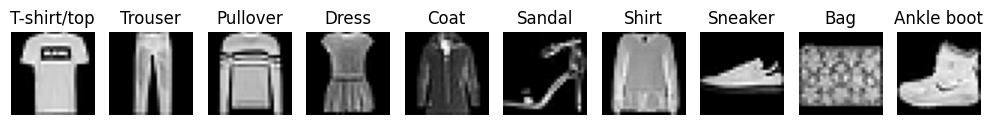

In [5]:
plt.figure(figsize=(10, 5))

# Etiquetas 
categories = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


for i in range(10):
    # Encontrar el primer ejemplo de la categoría actual
    example_index = np.where(y_train == i)[0][0]
    image = X_train[example_index]
    
    # Configurar un subgráfico para cada categoría
    plt.subplot(1, 10, i + 1)  # 2 filas, 5 columnas
    plt.imshow(image, cmap='gray')
    plt.title(categories[i])
    plt.axis('off') 

plt.tight_layout()
plt.show()

In [6]:
@tf.keras.utils.register_keras_serializable()
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
def plot_mnist_autoencoder(x, x_, y=None, y_=None, cmap='gray', vmin=0, vmax=1):
    """
    Plot the original and reconstructed MNIST images using an autoencoder, including labels.
    
    Parameters:
    ----------
    x : Sequence[np.ndarray]
        Original images.
    x_ : Sequence[np.ndarray]
        Reconstructed images.
    y : Optional[Sequence], optional
        True labels of the images, by default None.
    y_ : Optional[Sequence], optional
        Predicted labels of the images, by default None.
    cmap : str, optional
        Color map for the images, by default 'gray'.
    vmin : float, optional
        Minimum value for normalization, by default 0.
    vmax : float, optional
        Maximum value for normalization, by default 1.
    """
    plt.figure(figsize=(20, 4))
    num_images = len(x)
    
    for i in range(num_images):
        # Display original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(x[i].reshape(28, 28), cmap=cmap, vmin=vmin, vmax=vmax)
        if y is not None:
            plt.title(f'True: {y[i]}')
        plt.axis('off')
        
        # Display reconstructed image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(x_[i].reshape(28, 28), cmap=cmap, vmin=vmin, vmax=vmax)
        if y_ is not None:
            color = "red" if y is not None and y[i] != y_[i] else 'green'
            plt.title(f'Pred: {y_[i]}', color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [8]:
def compare_images(original_images, predicted_images, true_labels, label_names, indices, figsize=(10, 5)):
    """
    Función para comparar visualmente imágenes originales con las predicciones, mostrando también las etiquetas verdaderas.
    Args:
    original_images (numpy.array): Array de imágenes originales.
    predicted_images (numpy.array): Array de imágenes reconstruidas por el modelo, con la forma (n_samples, height, width, channels).
    true_labels (numpy.array): Array de etiquetas verdaderas para las imágenes originales.
    label_names (list): Lista de nombres de etiquetas correspondientes a las clases.
    indices (list of int): Lista de índices de las imágenes a comparar.
    figsize (tuple): Tamaño de la figura de matplotlib.
    """
    plt.figure(figsize=figsize)
    num_images = len(indices)

    for i, index in enumerate(indices):
        # Mostrar imagen original
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[index].squeeze(), cmap='gray')
        plt.title(f'Original {index}\nLabel: {label_names[true_labels[index]]}')
        plt.axis('off')

        # Mostrar imagen predicha
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(predicted_images[index].squeeze(), cmap='gray')
        plt.title(f'Reconstrucción {index}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [9]:
# Funciones de pérdida
def reconstruction_loss(y_true, y_pred):
    y_true_flat = tf.keras.backend.flatten(y_true)
    y_pred_flat = tf.keras.backend.flatten(y_pred)
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true_flat, y_pred_flat))

def dkl_loss(y_true, y_pred):
    # y_pred es z_gaussian
    latent_dim = y_pred.shape[1] // 2
    z_mean = y_pred[:, :latent_dim]
    z_log_var = y_pred[:, latent_dim:]
    return -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

# Criterio de dependencia usando imágenes y etiquetas predichas
def dependency_criterion(images, predicted_labels):
    """
    Calcula el criterio de dependencia entre las imágenes y las etiquetas predichas.
    
    Args:
    images (tensor): Imágenes de entrada del modelo.
    predicted_labels (tensor): Etiquetas predichas por el modelo.
    
    Returns:
    loss (tensor): La pérdida basada en la dependencia entre imágenes y etiquetas.
    """
    # Calcular la media de las imágenes y las etiquetas predichas
    f_mean = K.mean(images, axis=0)
    g_mean = K.mean(predicted_labels, axis=0)
    
    # Centramos las imágenes y las etiquetas predichas
    f_centered = images - f_mean
    g_centered = predicted_labels - g_mean
    
    # Calculamos la covarianza cruzada
    batch_size = tf.cast(tf.shape(images)[0], tf.float32)
    cov_xy = K.dot(K.transpose(f_centered), g_centered) / batch_size
    
    # Maximizar <g, Cxy f>
    loss = -tf.reduce_sum(tf.linalg.diag_part(cov_xy))  # Minimizar el negativo de la traza de la covarianza
    
    return loss


In [10]:
# Definir el modelo
def model_class(input_shape=(28, 28, 1), num_classes=10, latent_dim=128):
    # Encoder
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(6, kernel_size=3, activation='selu',
                               kernel_initializer=tf.keras.initializers.GlorotUniform(seed=12),
                               padding='same', name='conv1')(inputs)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.15)(x)
    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='selu',
                               kernel_initializer=tf.keras.initializers.GlorotUniform(seed=23),
                               padding='same', name='conv2')(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Conv2D(120, kernel_size=3, activation='selu',
                               kernel_initializer=tf.keras.initializers.GlorotUniform(seed=52),
                               padding='same', name='conv3')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.15)(x)

    z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)
    z_gaussian = tf.keras.layers.Concatenate(name='z_gaussian', axis=-1)([z_mean, z_log_var])
    z = Sampling()([z_mean, z_log_var])
    softmax_output = tf.keras.layers.Dense(num_classes, activation='softmax', name='softmax_output')(z)

    # Decoder
    x = tf.keras.layers.Dense(7 * 7 * 16, activation='selu')(z)
    x = tf.keras.layers.Reshape((7, 7, 16))(x)
    x = tf.keras.layers.Conv2DTranspose(16, kernel_size=3, activation='selu',
                                        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=12),
                                        padding='same')(x)
    x = tf.keras.layers.Dropout(0.15)(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2DTranspose(6, kernel_size=3, activation='selu',
                                        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=23),
                                        padding='same', name='conv2Transpose')(x)
    x = tf.keras.layers.Dropout(0.15)(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    reconstruction = tf.keras.layers.Conv2D(input_shape[2], kernel_size=3, padding='same',
                                            activation='sigmoid', name='reconstruction')(x)

    # VAE Model
    vae = tf.keras.models.Model(inputs, [reconstruction, z_gaussian, softmax_output], name='vae')
    return vae

# Construir y compilar el modelo
input_shape = (28, 28, 1)
num_classes = 10
latent_dim = 64
learning_rate = 1e-3

model = model_class(input_shape, num_classes, latent_dim)

# Definir y compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss={'reconstruction': reconstruction_loss,
                    'z_gaussian': dkl_loss,
                    'softmax_output': dependency_criterion},  # Usar el criterio de dependencia
              loss_weights={'reconstruction': 0.5,
                            'z_gaussian': 0.1,
                            'softmax_output': 0.4},  # Ajusta estos pesos según sea necesario
              metrics={'reconstruction': [reconstruction_loss],
                       'z_gaussian': [dkl_loss],
                       'softmax_output': [dependency_criterion]}
             )

In [14]:
seed = 42
epochs = 118
batch_size = 32
learning_rate =1e-2

In [ ]:
history = model.fit(X_train,
                    [X_train, X_train, y_train_one_hot],
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_valid, [X_valid, X_valid, y_valid_one_hot])
                   )

Epoch 1/118


I0000 00:00:1728355276.315039     148 service.cc:145] XLA service 0x785f4800ade0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728355276.315091     148 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728355276.315096     148 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  40/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2599 - reconstruction_reconstruction_loss: 0.6055 - softmax_output_dependency_criterion: -0.1853 - z_gaussian_dkl_loss: 0.3122  

I0000 00:00:1728355286.398335     148 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - loss: 0.0042 - reconstruction_reconstruction_loss: 0.3820 - softmax_output_dependency_criterion: -0.5713 - z_gaussian_dkl_loss: 0.4171 - val_loss: -0.0696 - val_reconstruction_reconstruction_loss: 0.3263 - val_softmax_output_dependency_criterion: -0.6804 - val_z_gaussian_dkl_loss: 0.3925
Epoch 2/118
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: -0.0667 - reconstruction_reconstruction_loss: 0.3322 - softmax_output_dependency_criterion: -0.6731 - z_gaussian_dkl_loss: 0.3645 - val_loss: -0.0767 - val_reconstruction_reconstruction_loss: 0.3200 - val_softmax_output_dependency_criterion: -0.6853 - val_z_gaussian_dkl_loss: 0.3715
Epoch 3/118
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: -0.0769 - reconstruction_reconstruction_loss: 0.3278 - softmax_output_dependency_criterion: -0.6901 - z_gaussian_dkl_loss: 0.3524 - val_loss: -0.0848 - val_reconstruction_reconstruction_loss: 0.3176 - val_softmax_output_dependency_criterion: -0.7026 - va

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
reconstruction_loss = history.history['reconstruction_reconstruction_loss']
val_reconstruction_loss = history.history['val_reconstruction_reconstruction_loss']
classification_loss = history.history['softmax_output_dependency_criterion']
val_classification_loss = history.history['val_softmax_output_dependency_criterion']
dkl_loss = history.history['z_gaussian_dkl_loss']
val_dkl_loss = history.history['val_z_gaussian_dkl_loss']

plt.figure(figsize=(14, 8))



# Gráfico para la pérdida de clasificación
plt.subplot(2, 2, 3)
plt.plot(classification_loss, label='Training Classification Loss')
plt.plot(val_classification_loss, label='Validation Classification Loss')
plt.title('Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()



# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [ ]:
X_re = model.predict(X_test)

# **Clasificación**

In [ ]:
X_re[2].shape

In [ ]:
# Obtén las predicciones de clasificación
softmax_output = X_re[2]  
predicted_labels = np.argmax(softmax_output, axis=1)

accuracy = accuracy_score(y_test, predicted_labels)
print("Accuracy:", accuracy)
print(classification_report(y_test, predicted_labels))